In [2]:
import os, sys, math, random, argparse
import numpy as np
import matplotlib.pyplot as plt

path = os.getcwd()
random.seed(100)

In [52]:
# 모델의 적합한 input이 모두 다르다

for input in os.listdir('/data/HiHiC-main'):
    if input.startswith('data_') and input.find(".") == -1:
        data_dir = input
        if 'test_KR_300' in os.listdir('/data/HiHiC-main/' + data_dir):
            print("\n", input)
            if os.listdir('/data/HiHiC-main/'+ input + '/test_KR_300/')[0].endswith(".npz"):
                print(np.load('/data/HiHiC-main/'+ input + '/test_KR_300/test_ratio16.npz').files)
                print(np.load('/data/HiHiC-main/'+ input + '/test_KR_300/test_ratio16.npz')['target'].shape)
            else:
                print(np.load('/data/HiHiC-main/'+ input + '/test_KR_300/test_ratio16.npy').shape)



 data_hicplus
['data', 'target', 'inds', 'inds_target']
(4081, 1, 40, 40)

 data_HiCNN
['data', 'target', 'inds', 'inds_target']
(4081, 1, 40, 40)

 data_DeepHiC
['data', 'target', 'inds', 'compacts', 'sizes']
(4081, 1, 40, 40)

 data_SRHiC
(4081, 40, 68)

 data_HiCARN
['data', 'target', 'inds', 'compacts', 'sizes']
(4081, 1, 40, 40)

 data_DFHiC
['data', 'target', 'inds', 'distance']
(4081, 40, 40, 1)


In [55]:
# 모델의 output 또한 모두 다르다

for out in os.listdir('/data/HiHiC-main/output_enhanced'):
    mat = np.load('/data/HiHiC-main/output_enhanced/' + out)
    print("\n",out)
    print(mat.files, mat['data'].shape)


 DeepHiC_predict_16_00042.npz
['data', 'inds'] (4081, 1, 40, 40)

 DFHiC_predict_16_00100.npz
['data', 'inds'] (4081, 40, 40, 1)

 HiCNN2_predict_16_00100.npz
['data', 'inds'] (4081, 1, 28, 28)

 SRHiC_predict_16_00089.npz
['data', 'inds'] (4081, 28, 28, 1)

 hicplus_predict_16_00100.npz
['data', 'inds'] (4081, 1, 28, 28)

 HiCARN_predict_16_00021.npz
['data', 'inds'] (4081, 1, 40, 40)


In [63]:
# 크로모좀 단위로 합쳐주기

def make_whole_40(predicted, save_filename):
    predicted = np.load(predicted, allow_pickle=True)
    mats = {}
    unique_chrom = np.unique(predicted['inds'][:, 0])
    for chrom in sorted(unique_chrom):
        chrom_indices = predicted['inds'][:, 0] == chrom
        mat_dim = predicted['inds'][chrom_indices][0, 1] + 1
        inds = predicted['inds'][chrom_indices][:, -2:] + [6, 6]
        submats = np.squeeze(predicted['data'])[chrom_indices, 6:34, 6:34]    
        mat = np.zeros((mat_dim, mat_dim))
        for ind, submat in zip(inds, submats):
            mat[ind[0]:ind[0]+28, ind[1]:ind[1]+28] = submat
        mats[str(chrom)] = np.triu(mat) + np.triu(mat, k=1).T # mats[str(chrom)] = mat
    np.savez_compressed(save_filename, **mats)
    
    
def make_whole_28(predicted, save_filename):
    predicted = np.load(predicted, allow_pickle=True)
    mats = {}
    unique_chrom = np.unique(predicted['inds'][:, 0])
    for chrom in sorted(unique_chrom):
        chrom_indices = predicted['inds'][:, 0] == chrom
        mat_dim = predicted['inds'][chrom_indices][0, 1] + 1
        inds = predicted['inds'][chrom_indices][:, -2:]
        submats = np.squeeze(predicted['data'])[chrom_indices, :, :]
        mat = np.zeros((mat_dim, mat_dim))
        for ind, submat in zip(inds, submats):
            mat[ind[0]:ind[0]+28, ind[1]:ind[1]+28] = submat
        mats[str(chrom)] = np.triu(mat) + np.triu(mat, k=1).T # mats[str(chrom)] = mat
    np.savez_compressed(save_filename, **mats)
    
os.makedirs('/data/HiHiC-main/output_chrom/', exist_ok=True)
for out in os.listdir('/data/HiHiC-main/output_enhanced'):
    mat = np.load('/data/HiHiC-main/output_enhanced/' + out)
    model = out.split('_')[0]
    
    if model == 'SRHiC':
        predicted = np.load('/data/HiHiC-main/output_enhanced/' + out, allow_pickle=True)
        index_file = os.path.join("/data/HiHiC-main/data_SRHiC/test_KR_300/index_test_ratio16.npz")
        index = np.load(index_file, allow_pickle=True)['inds_target']
        mats = {}
        unique_chrom = np.unique(index[:, 0])
        for chrom in sorted(unique_chrom):
            chrom_indices = index[:, 0] == chrom
            mat_dim = index[chrom_indices][0, 1] + 1
            inds = index[chrom_indices][:, -2:]
            submats = np.squeeze(predicted['data'])[chrom_indices, :, :]
            mat = np.zeros((mat_dim, mat_dim))
            for ind, submat in zip(inds, submats):
                mat[ind[0]:ind[0]+28, ind[1]:ind[1]+28] = submat
            mats[str(chrom)] = np.triu(mat) + np.triu(mat, k=1).T # mats[str(chrom)] = mat
        np.savez_compressed('/data/HiHiC-main/output_chrom/' + model + '.npz', **mats)
    
    elif np.squeeze(mat['data']).shape[-1] == 40:
        make_whole_40('/data/HiHiC-main/output_enhanced/' + out, '/data/HiHiC-main/output_chrom/' + model + '.npz')
        
    else:      
        make_whole_28('/data/HiHiC-main/output_enhanced/' + out, '/data/HiHiC-main/output_chrom/' + model + '.npz')

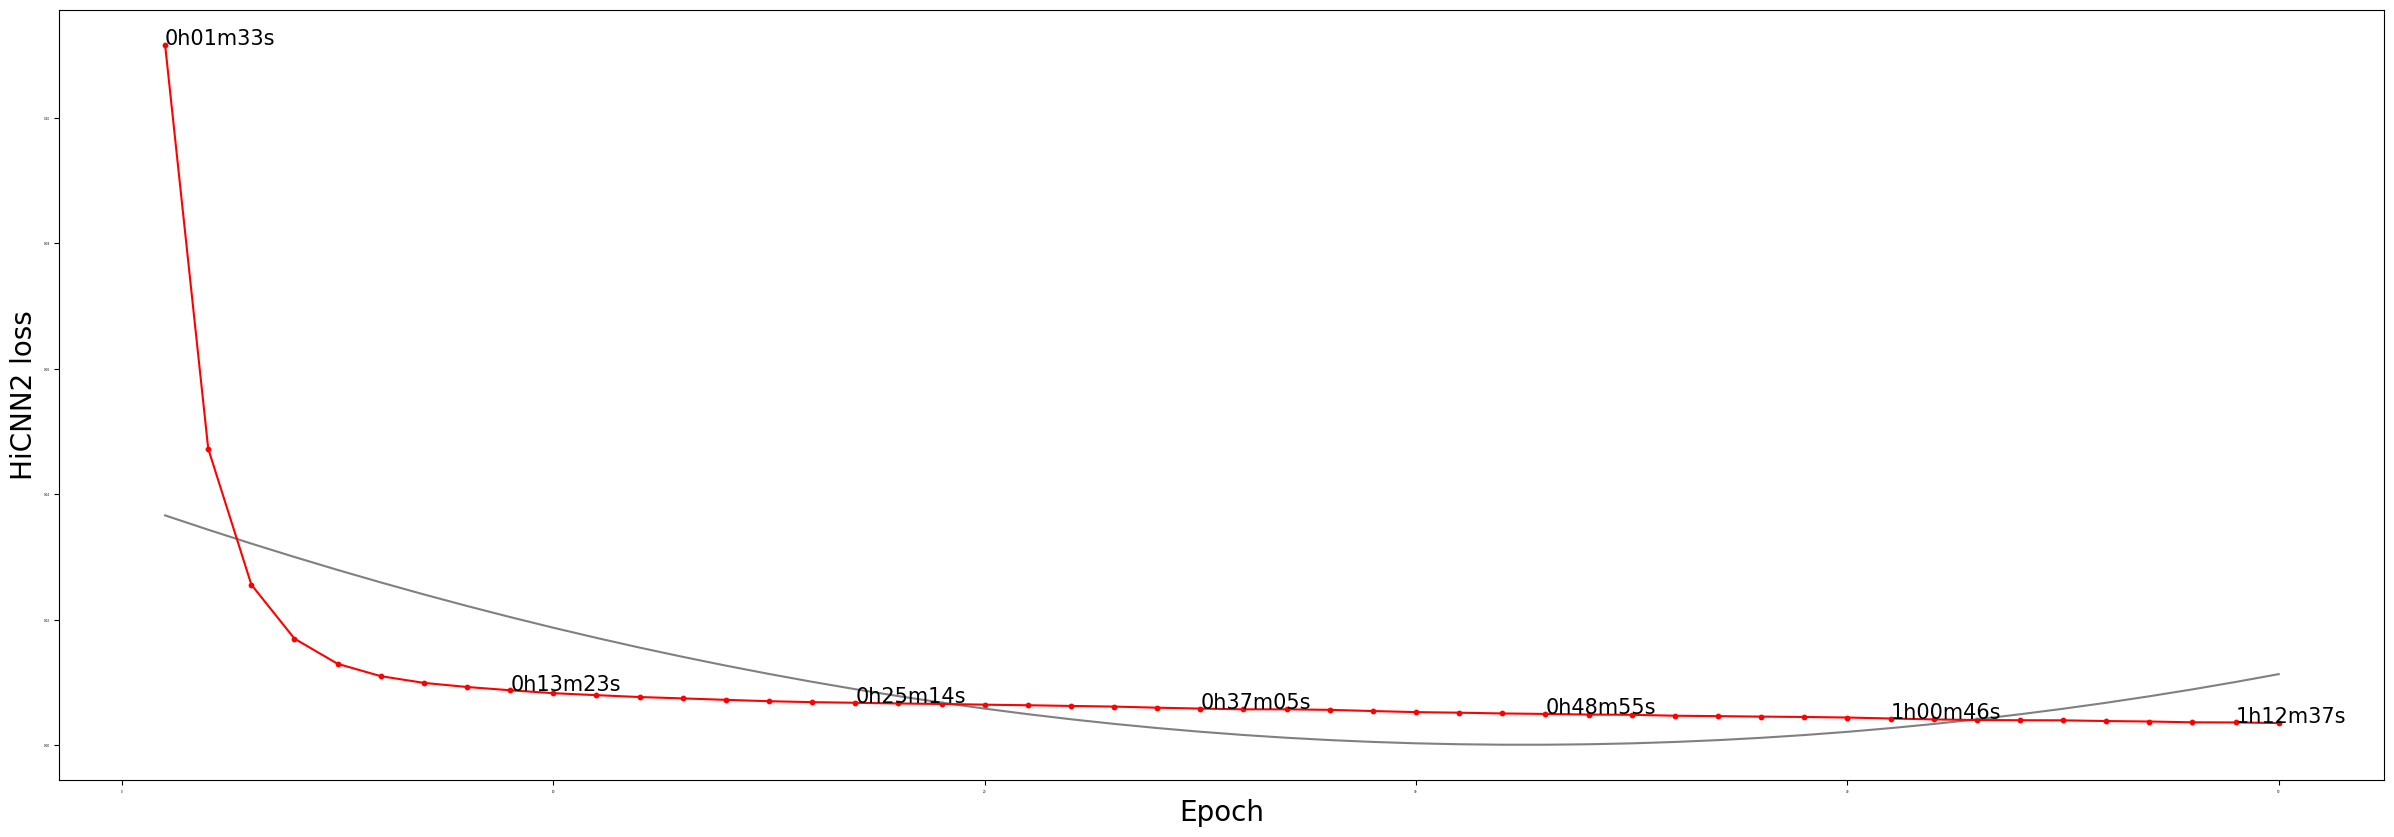

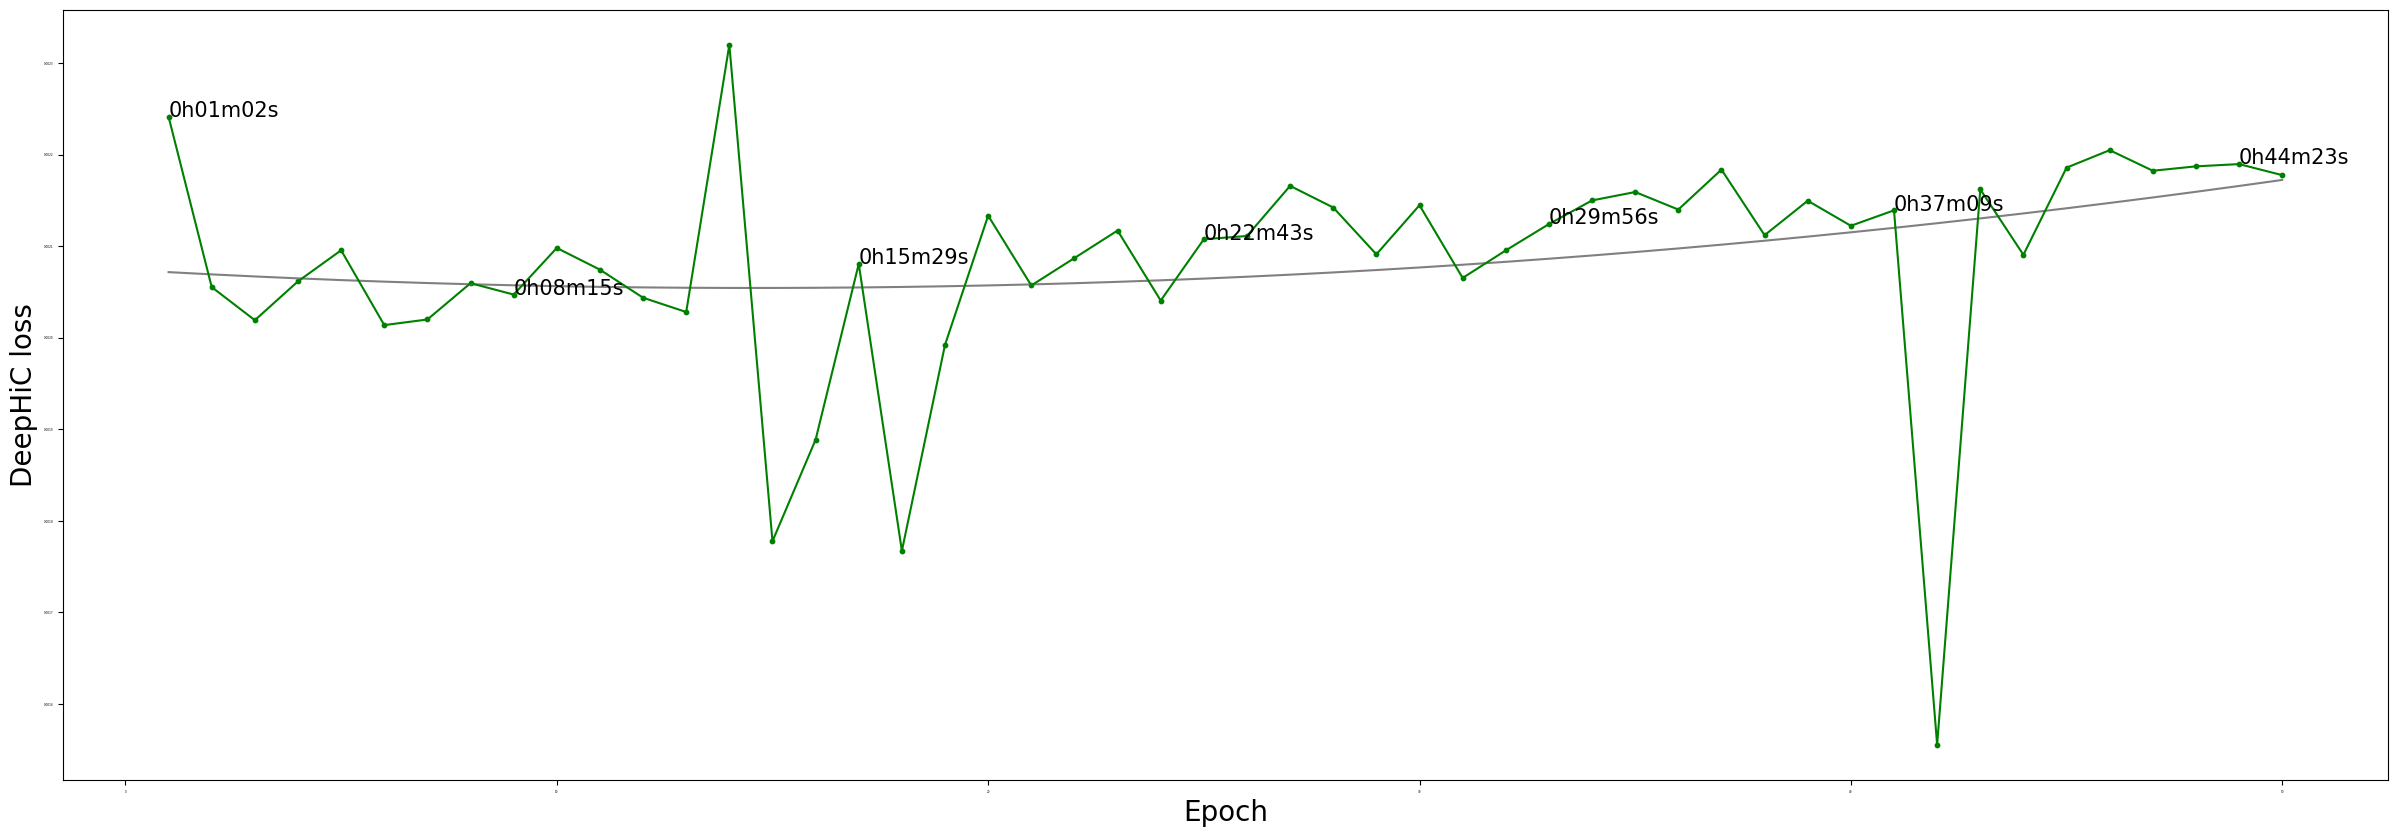

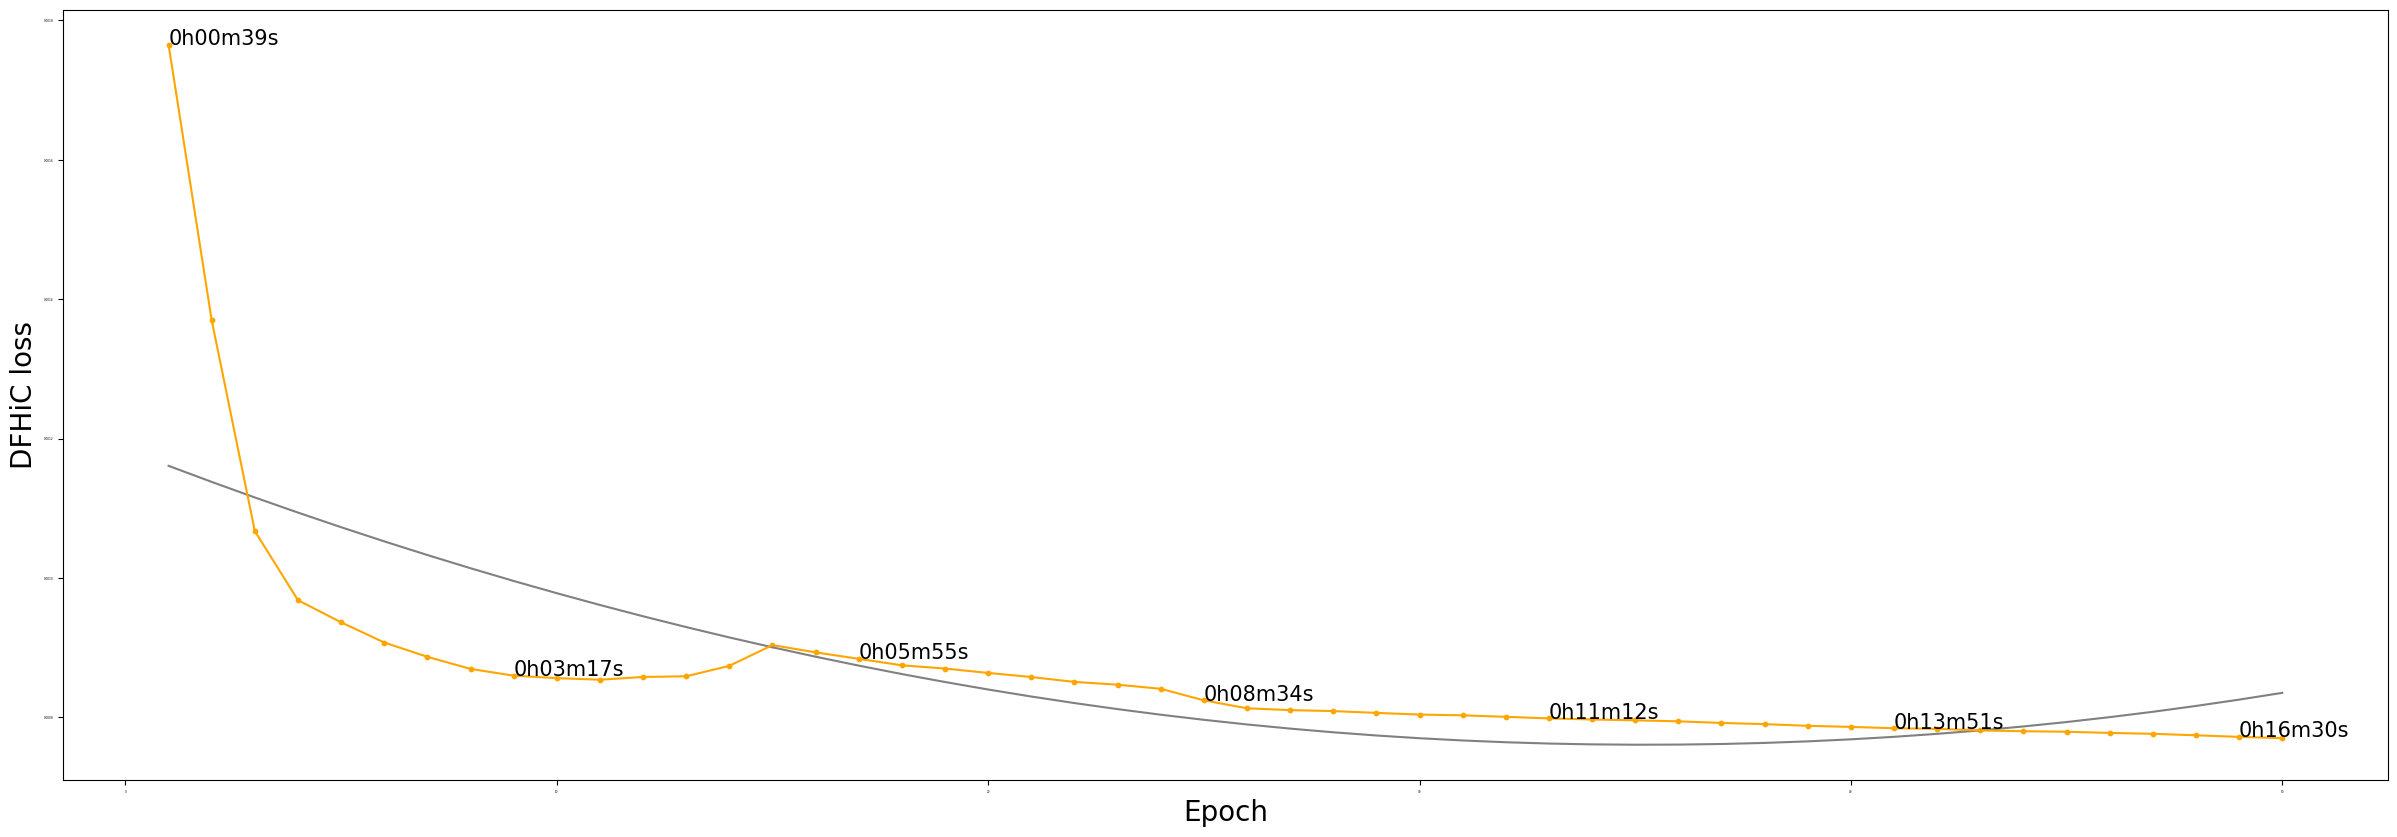

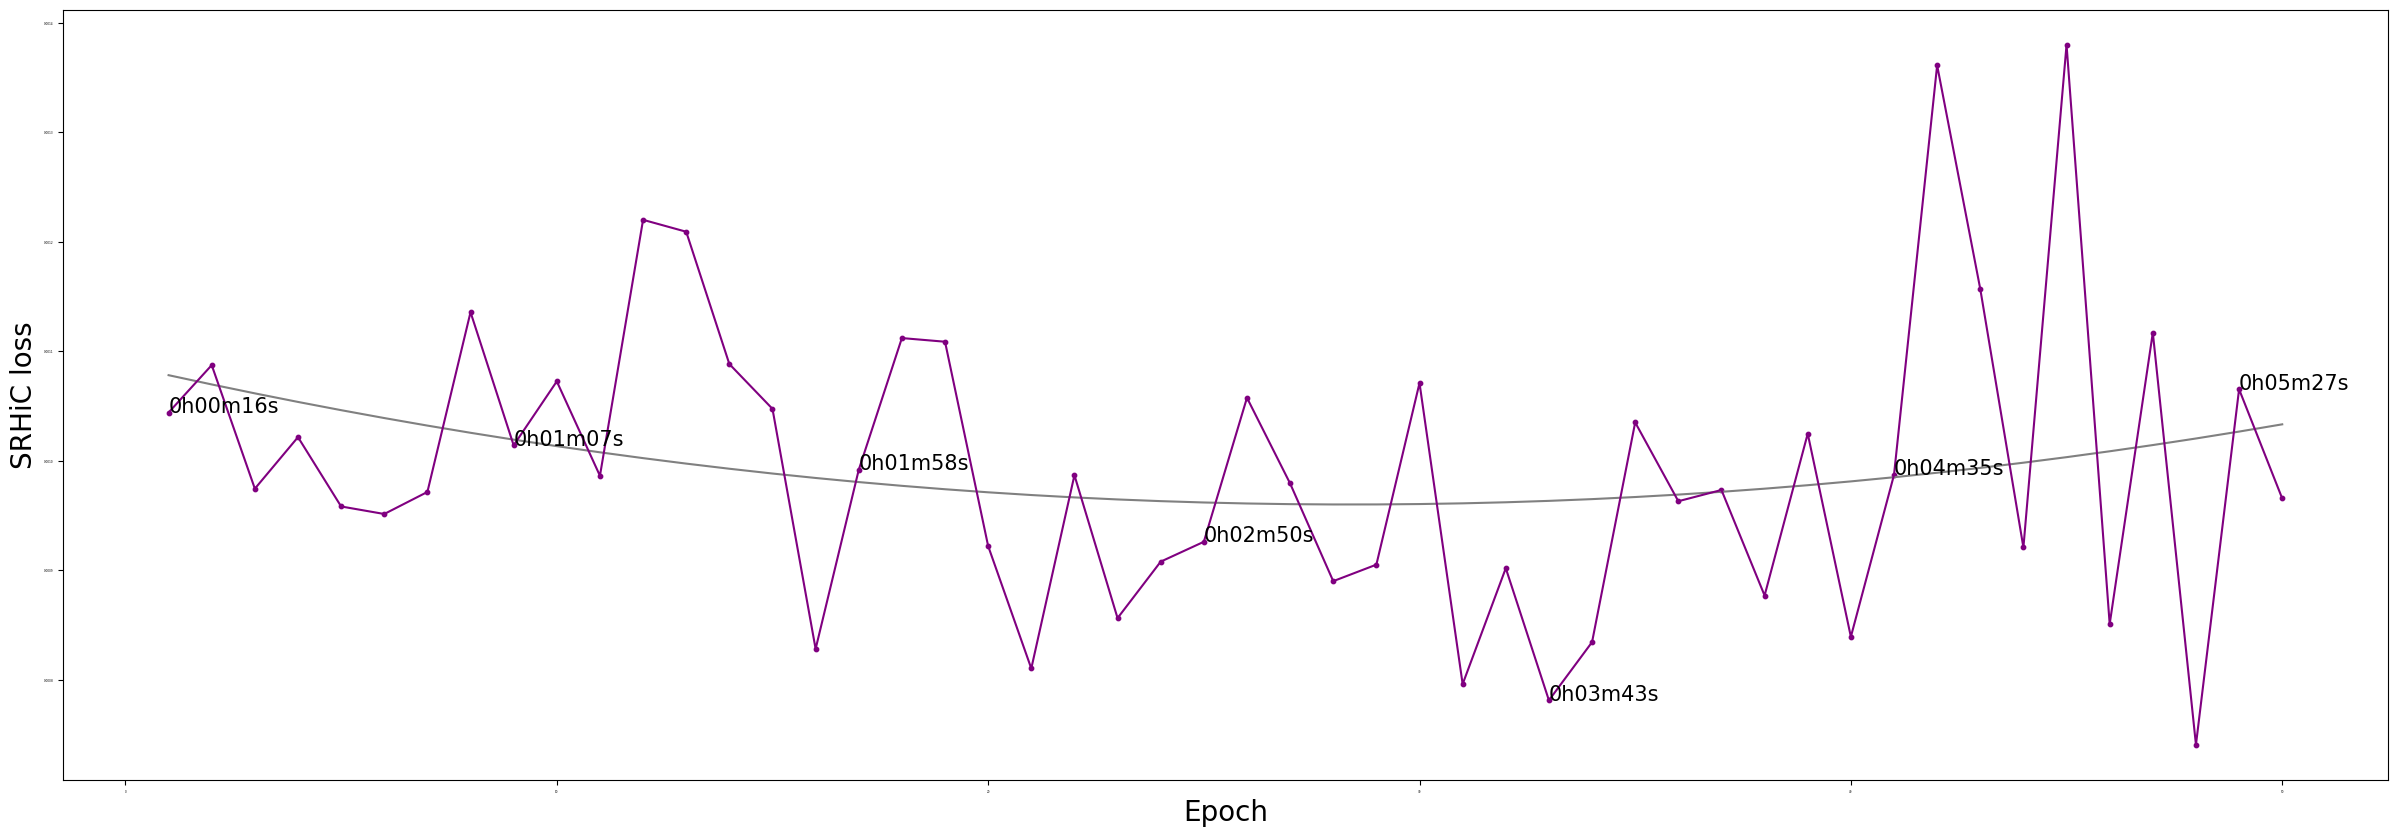

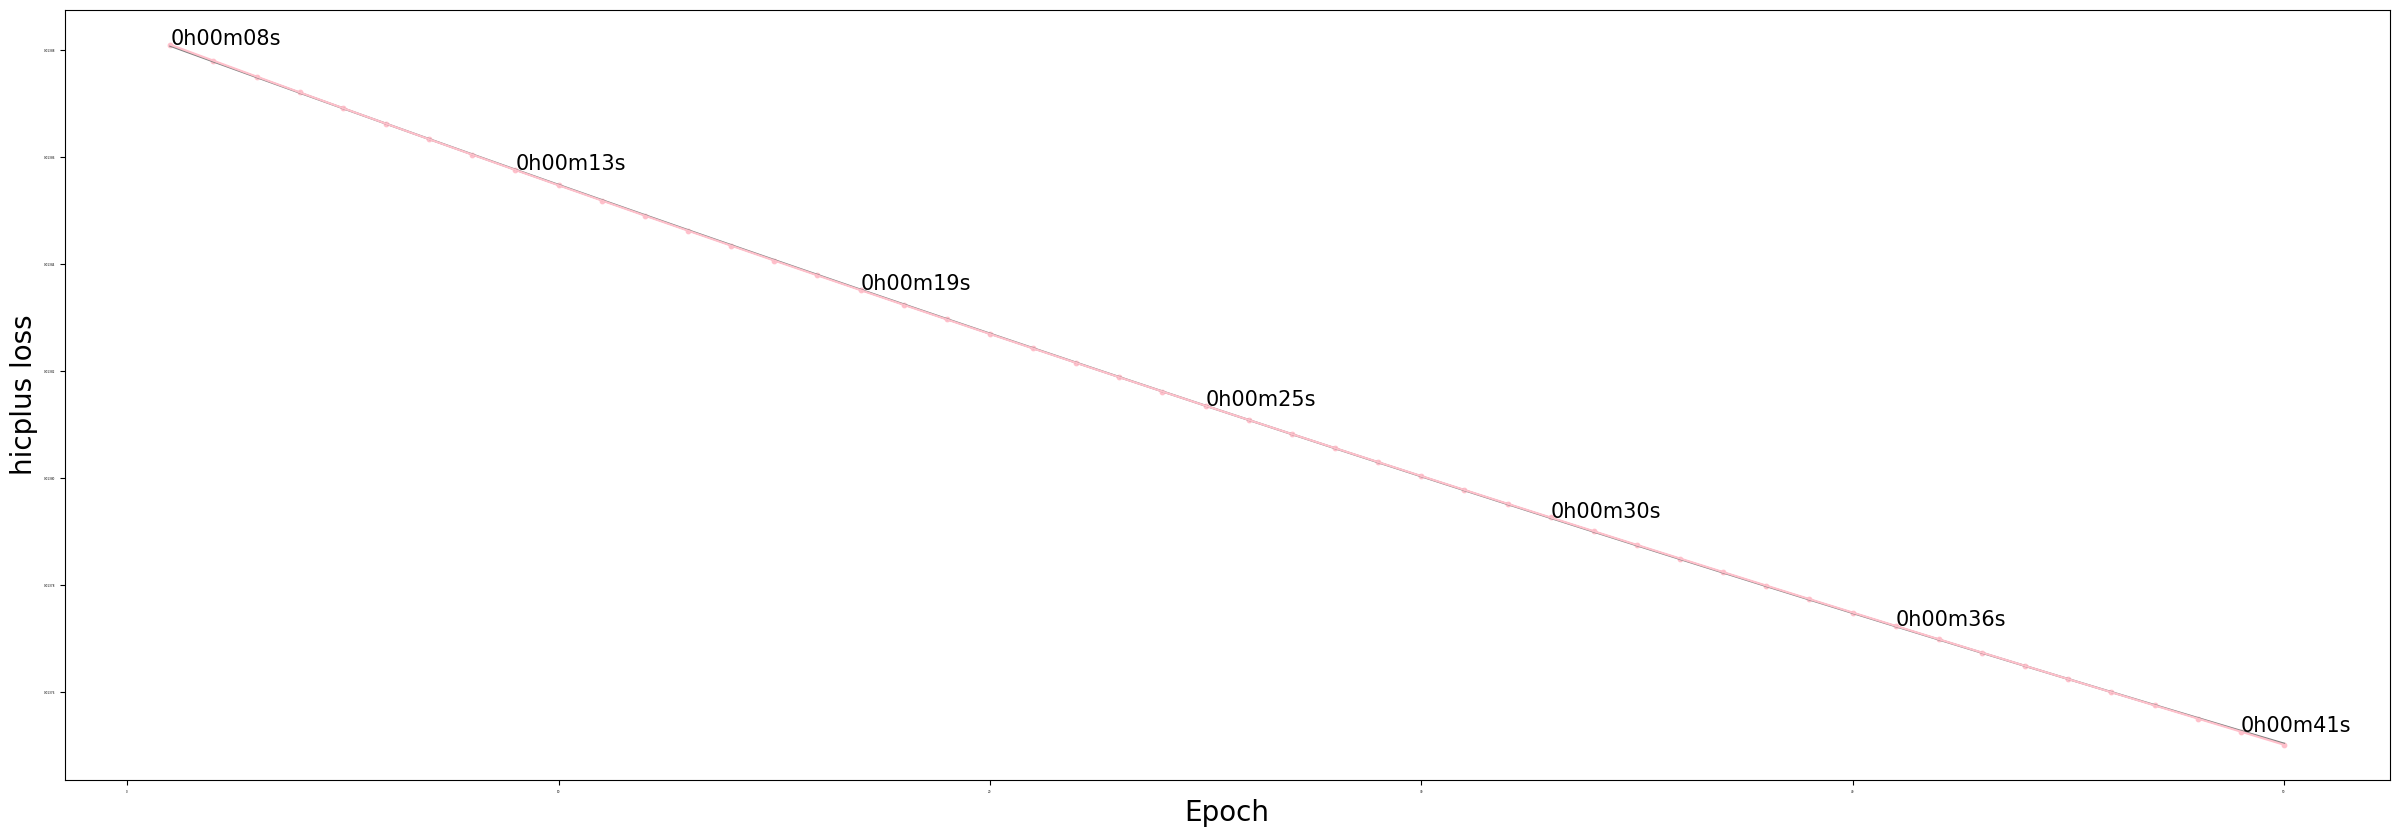

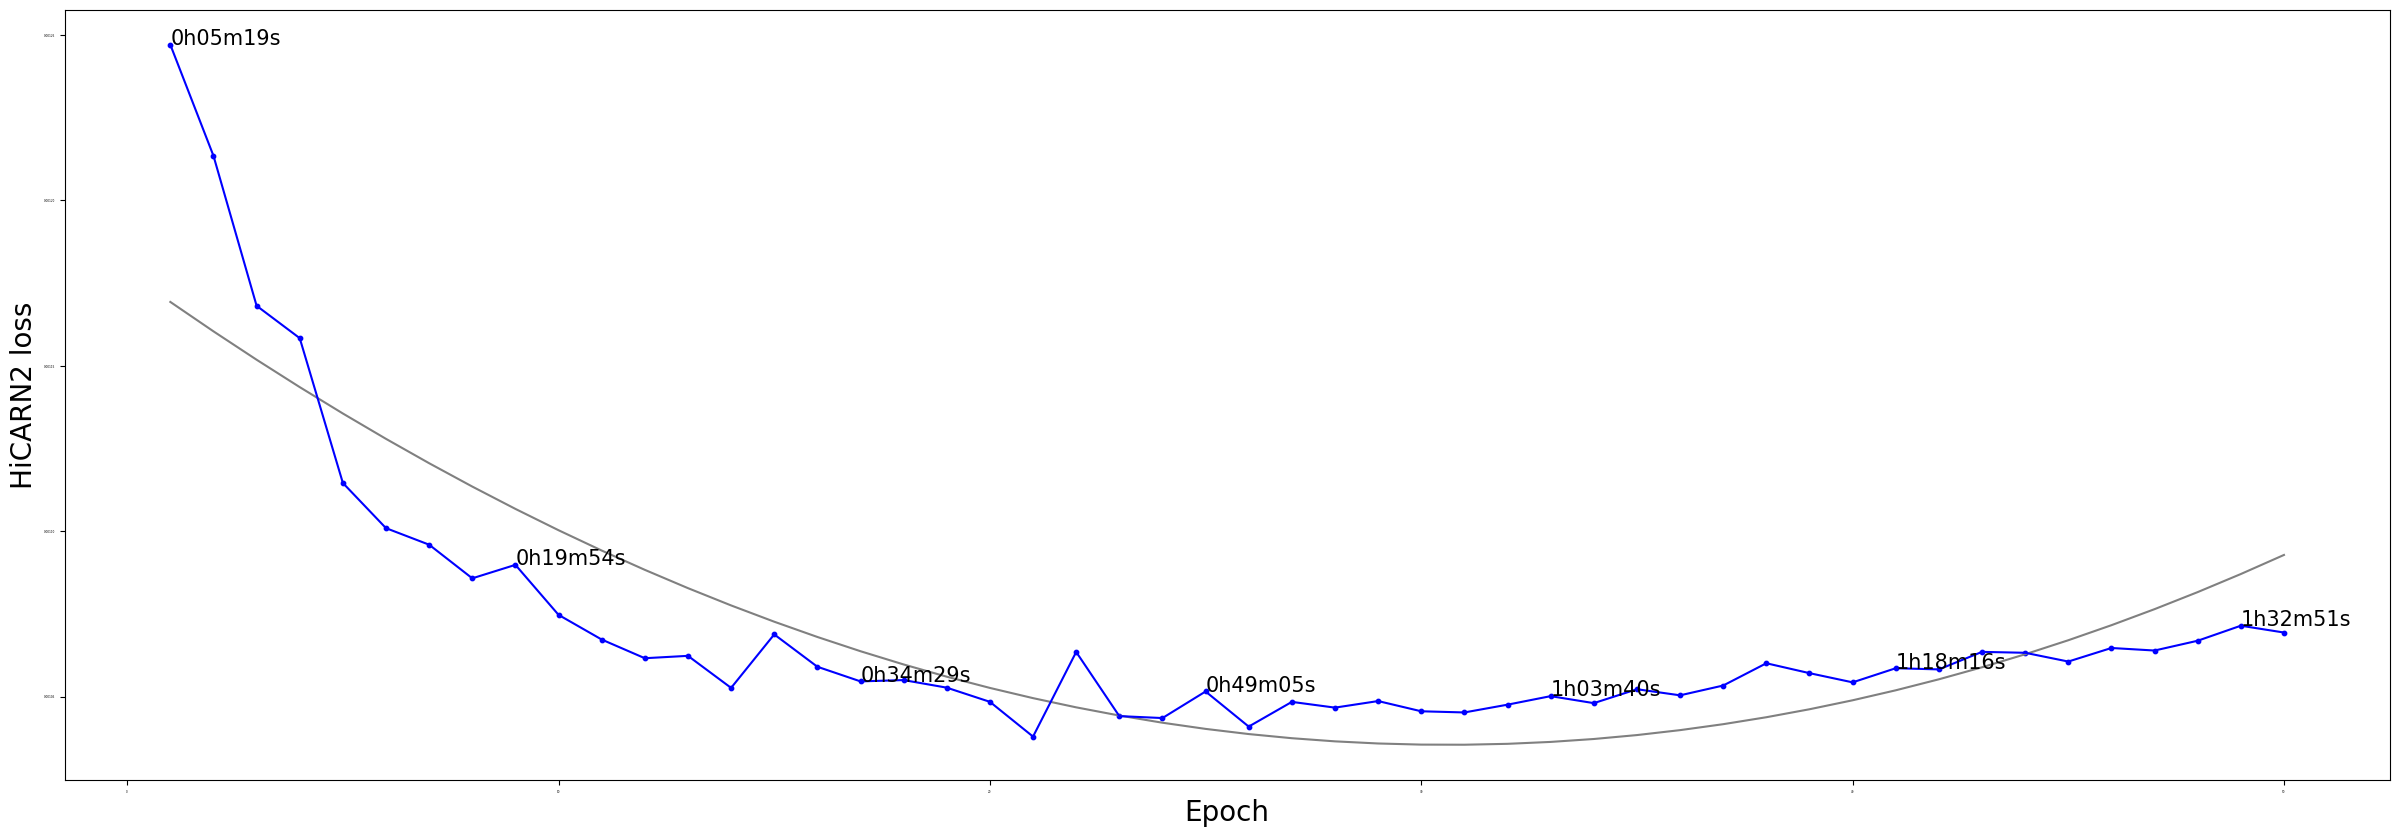

In [73]:
# loss

plt.rcParams.update({'font.size': 2})

for i, c in zip(os.listdir("/data/HiHiC-main/log_KR_300/"),
                ['red', 'green', 'orange', 'purple', 'pink', 'blue']):
    model=i.split("_")[-1].split(".")[0]
    plt.figure(figsize=(30,10))
    i = np.load("/data/HiHiC-main/log_KR_300/" + i)
    x = i[0][:50].astype(np.int32)
    y = i[2][:50].astype(np.float32)
    plt.scatter(x,y, s=10, c=c)
    z = np.polyfit(x,y, 2)
    p = np.poly1d(z)
    plt.plot(x, p(x), color='gray')
    plt.plot(x, y, color=c, label=model)
    for i, (xx, yy, time) in enumerate(zip(x, y, i[1][:50])):
        if i%8 ==0:
            plt.text(xx, yy, time.replace('.','h', 1).replace('.', 'm', 1)+'s', fontsize="15")
    # plt.ylim([0.39, 0.42]) # [0.39, 0.42]
    plt.xlabel("Epoch", fontsize="20")
    plt.ylabel(model+" loss", fontsize="20")
    # plt.legend(fontsize="20")
    # plt.savefig('loss_trend.png')
    plt.show()

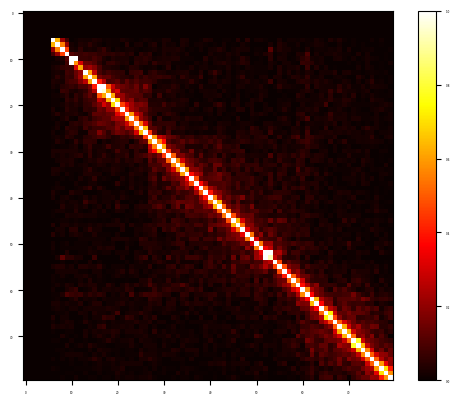

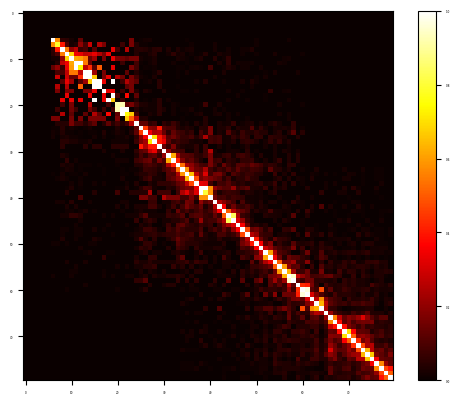

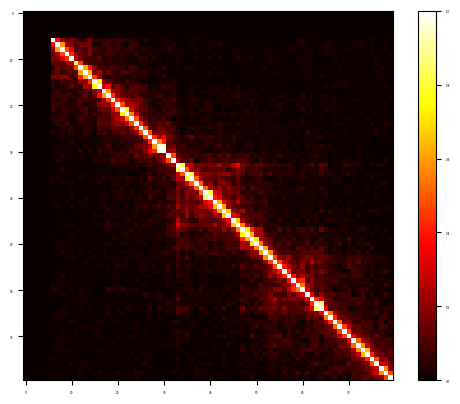

In [81]:
x = np.load("/data/HiHiC-main/data_HiCNN/test/test_ratio16.npz")

predicted = "/data/HiHiC-main/data_HiCNN/test_KR_300/test_ratio16.npz"
save_filename = '/data/HiHiC-main/output_chrom/target.npz'

predicted = np.load(predicted, allow_pickle=True)
mats = {}
unique_chrom = np.unique(predicted['inds'][:, 0])
for chrom in sorted(unique_chrom):
    chrom_indices = predicted['inds'][:, 0] == chrom
    mat_dim = predicted['inds'][chrom_indices][0, 1] + 1
    inds = predicted['inds'][chrom_indices][:, -2:] + [6, 6]
    submats = np.squeeze(predicted['target'])[chrom_indices, 6:34, 6:34]    
    mat = np.zeros((mat_dim, mat_dim))
    for ind, submat in zip(inds, submats):
        mat[ind[0]:ind[0]+28, ind[1]:ind[1]+28] = submat
    mats[str(chrom)] = np.triu(mat) + np.triu(mat, k=1).T # mats[str(chrom)] = mat
np.savez_compressed(save_filename, **mats)

file = np.load(save_filename)
for chr in ['18','19','20','21','22']:
    plt.imshow(file[chr][0:80, 0:80], cmap='hot')
    plt.colorbar()
    plt.show()

HiCNN2.npz
True
18
(7809, 7809) 



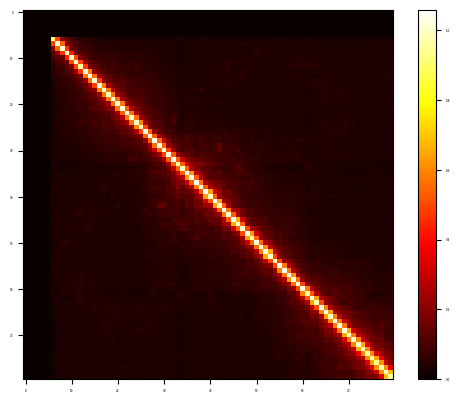

True
19
(5914, 5914) 



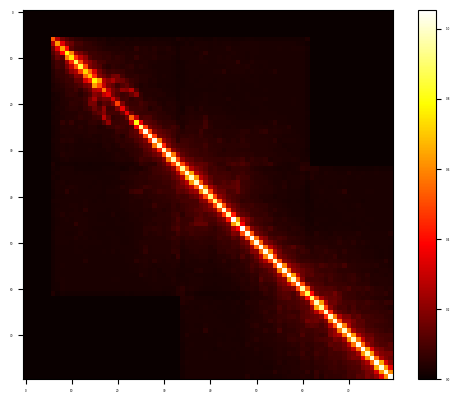

True
20
(6304, 6304) 



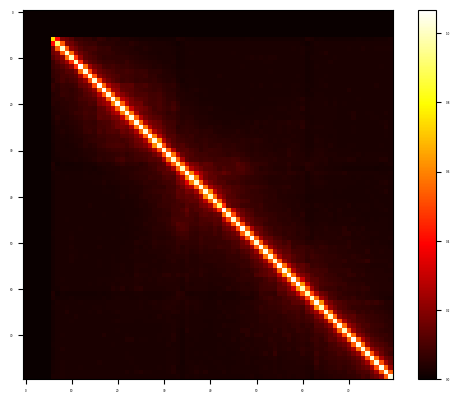

SRHiC.npz
True
18
(7809, 7809) 



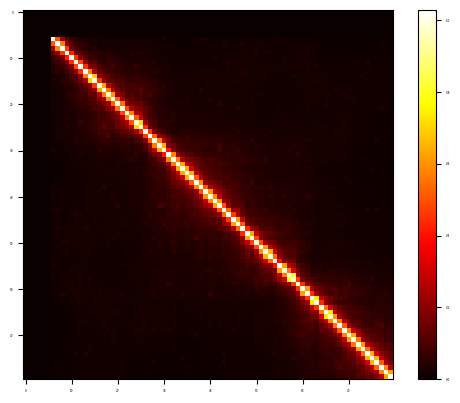

True
19
(5914, 5914) 



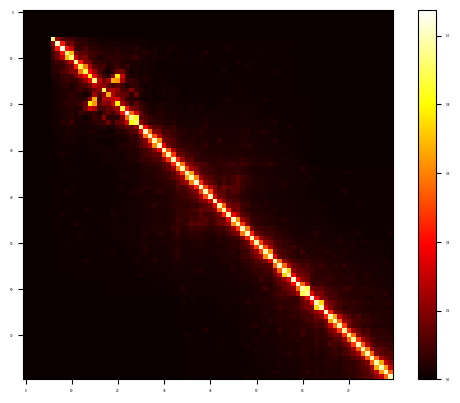

True
20
(6304, 6304) 



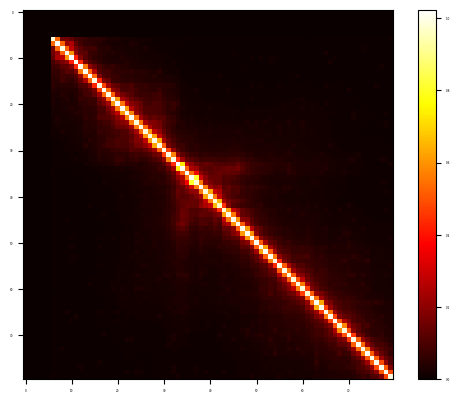

HiCARN.npz
True
18
(7809, 7809) 



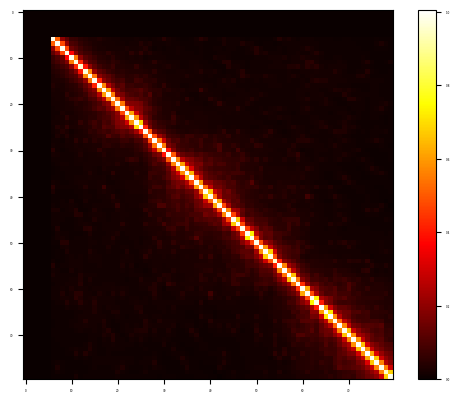

True
19
(5914, 5914) 



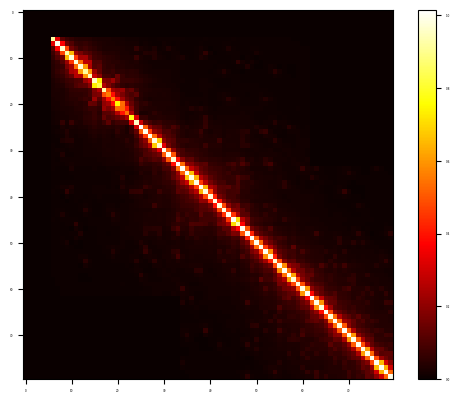

True
20
(6304, 6304) 



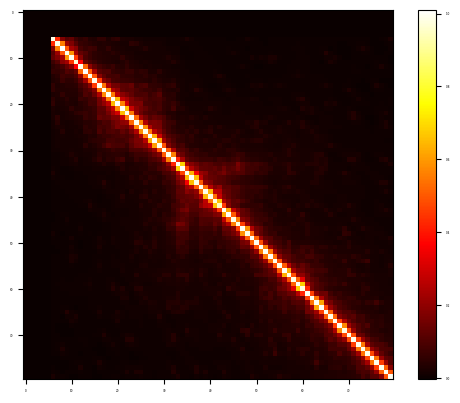

hicplus.npz
True
18
(7809, 7809) 



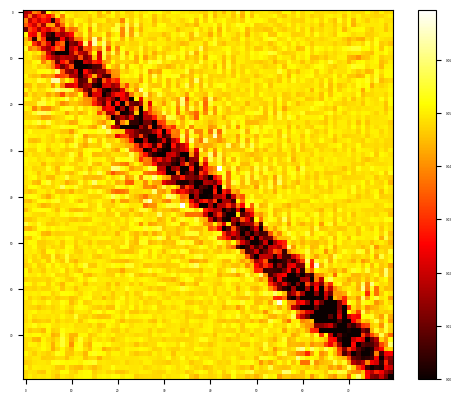

True
19
(5914, 5914) 



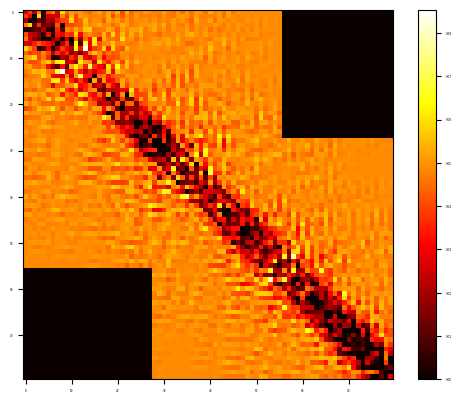

True
20
(6304, 6304) 



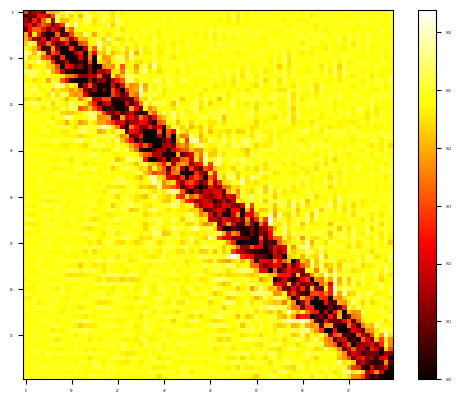

DFHiC.npz
True
18
(7809, 7809) 



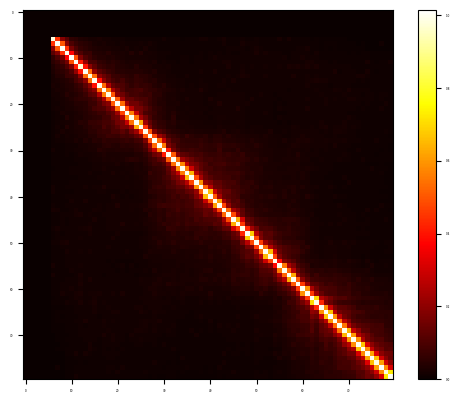

True
19
(5914, 5914) 



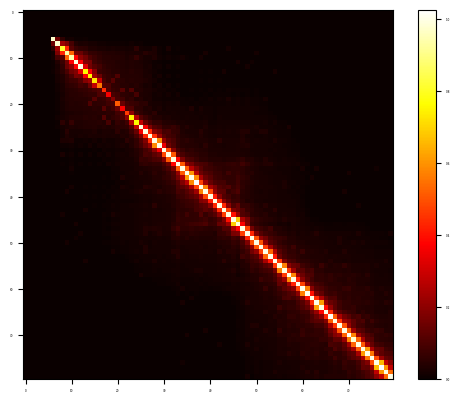

True
20
(6304, 6304) 



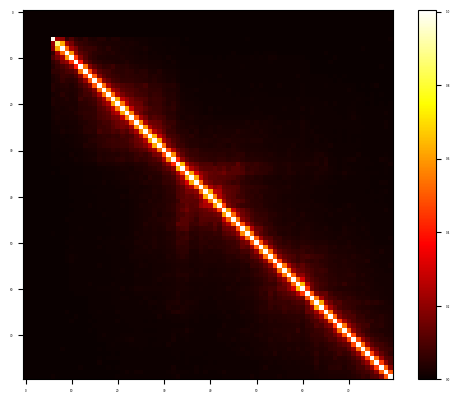

DeepHiC.npz
True
18
(7809, 7809) 



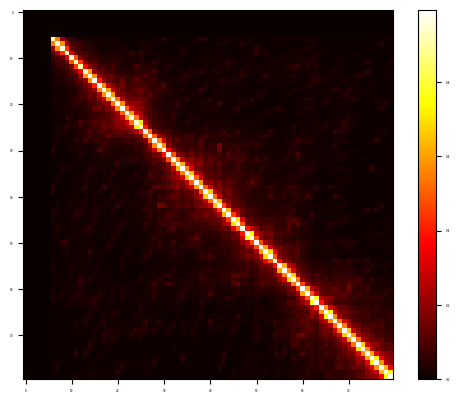

True
19
(5914, 5914) 



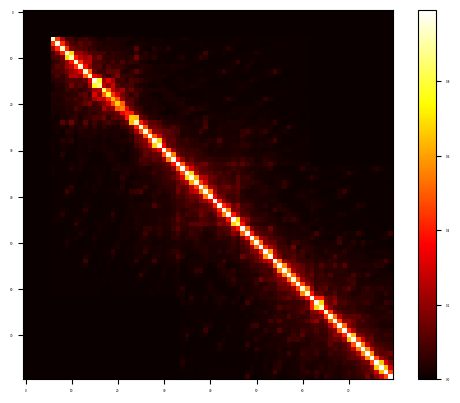

True
20
(6304, 6304) 



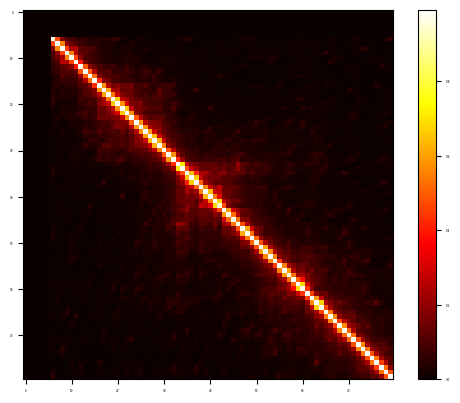

In [75]:
for out in os.listdir("/data/HiHiC-main/output_chrom"):
    print(out)
    file = np.load("/data/HiHiC-main/output_chrom/"+out)
    for chr in ['18','19','20']:
        print(np.allclose(file[chr], file[chr].T))
        print(chr)
        print(file[chr].shape, '\n')
        plt.imshow(file[chr][0:80, 0:80], cmap='hot')
        plt.colorbar()
        plt.show()